# Lesson 2 - Batching

In this lesson, we'll discuss the concept of "batching" in LLM inference.

- What is batching?
- Throughput vs latency

## Import required packages and load the LLM

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

/home/kaushik/miniconda3/envs/py3_efficiently_serving_llms_course/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

/home/kaushik/miniconda3/envs/py3_efficiently_serving_llms_course/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/kaushik/miniconda3/envs/py3_efficiently_serving_llms_course/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Reuse KV-cache text generation function from Lesson 1
- Use the same prompt as the previous lesson to verify everything is working as expected

In [3]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")

def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()

    return next_token_id, outputs.past_key_values

def generate(inputs, max_tokens):
    generated_tokens = []
    next_inputs = inputs
    
    for _ in range(max_tokens):
        next_token_id, past_key_values = generate_token_with_past(next_inputs)

        next_inputs = {
            "input_ids": next_token_id.reshape((1,1)),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])],
                dim=1
            ),
            "past_key_values": past_key_values
        }

        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)

    return "".join(generated_tokens)

tokens = generate(inputs=inputs, max_tokens=10)
print(tokens)

 fence and ran to the other side of the fence


## Add padding tokens to the model to prepare batches of prompts

In [4]:
tokenizer.pad_token

In [5]:
tokenizer.eos_token

'<|endoftext|>'

In [6]:
model.config

GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.35.2",
  "use_cache": true,
  "vocab_size": 50257
}

In [7]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

Pad on the left so we can append new tokens on the right

In [8]:
tokenizer.padding_side

'right'

In [9]:
tokenizer.truncation_side

'right'

In [10]:
tokenizer

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [11]:
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

- Tokenize list of prompts
- Add padding so that all prompts have the same number of tokens as the longest prompt

In [12]:
# multiple prompts of varying lengths to send
# to the model at once
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# note: padding=True ensures the padding token
# will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

Let's check the input_ids

In [13]:
print(f"input_ids: {inputs['input_ids']}")
print(f"shape: {inputs['attention_mask'].shape}")

input_ids: tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [50256, 50256,   464,  6290,   287,  8602,  8953],
        [50256, 50256, 50256,  2061,  2058,   510,  1276]])
shape: torch.Size([3, 7])


Let's check the attention_mask

In [14]:
print(f"attention_mask: {inputs['attention_mask']}")
print(f"shape: {inputs['attention_mask'].shape}")

attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])
shape: torch.Size([3, 7])


- Add position ids to track original order of tokens in each prompt
- Padding tokens are set to `1` and then first real token starts with position `0`

In [15]:
# position_ids tell the transformer the ordinal position
# of each token in the input sequence
# for single input inference, this is just [0 .. n]
# for n tokens, but for batch inference,
# we need to 0 out the padding tokens at the start of the sequence
attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids

tensor([[ 0,  1,  2,  3,  4,  5,  6],
        [-1, -1,  0,  1,  2,  3,  4],
        [-1, -1, -1,  0,  1,  2,  3]])

In [16]:
position_ids.masked_fill_(attention_mask==0, 1)

tensor([[0, 1, 2, 3, 4, 5, 6],
        [1, 1, 0, 1, 2, 3, 4],
        [1, 1, 1, 0, 1, 2, 3]])

- KA: Let's check how position_ids would be added to next_inputs

In [17]:
position_ids[:, -1]

tensor([6, 4, 3])

In [ ]:
# Reshape and increment
position_ids[:, -1].unsqueeze(-1) + 1

tensor([[7],
        [5],
        [4]])

In [31]:
position_ids[:, -1].unsqueeze(-1).shape

torch.Size([3, 1])

- Pass tokens to model to calculate logits

In [19]:
# same as before, but include the position_ids
with torch.no_grad():
    outputs = model(position_ids=position_ids, **inputs)

logits = outputs.logits

- Retrieve most likely token for each prompt

In [20]:
last_logits = logits[:, -1, :]
next_token_ids = last_logits.argmax(dim=1)

- Print the next token ids

In [21]:
print(next_token_ids)

tensor([13990,   319,   307])


- Convert the token ids into strings

In [22]:
next_tokens = tokenizer.batch_decode(next_token_ids)
next_tokens

[' fence', ' on', ' be']

### KA: Let's analyze a) past_key_values and b) input_ids_length 

https://huggingface.co/docs/transformers/main/en/model_doc/gpt2#transformers.GPT2Model.forward.input_ids

In [ ]:
# Number of layers
len(outputs.past_key_values)

12

In [ ]:
# Key, Value tuple of one of the layer
len(outputs.past_key_values[0])

2

In [36]:
outputs.past_key_values[0][0].shape

torch.Size([3, 12, 7, 64])

In [37]:
outputs.past_key_values[0][1].shape

torch.Size([3, 12, 7, 64])

## Let's put it all together!
 - Generate n tokens with past

In [23]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return next_token_ids, outputs.past_key_values

- Generate all tokens for some max tokens

In [38]:
def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask==0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = generate_batch_tokens_with_past(next_inputs)

        print(f"past_key_values[0][0].shape: {past_key_values[0][0].shape}")
        
        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1))
            ], dim=1),
            "past_key_values": past_key_values
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)

        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)

    return ["".join(tokens) for tokens in generated_tokens]

- Call the generate_batch function and print out the generated tokens

In [39]:
generated_tokens = generate_batch(inputs, max_tokens=10)

past_key_values[0][0].shape: torch.Size([128, 12, 7, 64])
past_key_values[0][0].shape: torch.Size([128, 12, 8, 64])
past_key_values[0][0].shape: torch.Size([128, 12, 9, 64])
past_key_values[0][0].shape: torch.Size([128, 12, 10, 64])
past_key_values[0][0].shape: torch.Size([128, 12, 11, 64])
past_key_values[0][0].shape: torch.Size([128, 12, 12, 64])
past_key_values[0][0].shape: torch.Size([128, 12, 13, 64])
past_key_values[0][0].shape: torch.Size([128, 12, 14, 64])
past_key_values[0][0].shape: torch.Size([128, 12, 15, 64])
past_key_values[0][0].shape: torch.Size([128, 12, 16, 64])


In [26]:
for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

The quick brown fox jumped over the  fence and ran to the other side of the fence

The rain in Spain falls  on the first day of the month, and the

What comes up must  be a good idea.

"I think



## Throughput vs Latency

- Explore the effect of batching on latency (how long it takes to generate each token). 
- Observe the fundamental tradeoff that exists between throughput and latency.

In [27]:
# constants
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(8)]

for batch_size in batch_sizes:
    print(f"Batch size: {batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]
    inputs = tokenizer(batch_prompts, padding=True, return_tensors="pt")
    generated_tokens = generate_batch(inputs=inputs, max_tokens=max_tokens)
    duration_s = time.time() - t0

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens

    print(f"duration: {duration_s}")
    print(f"throughput: {throughput}")
    print(f"avg latency: {avg_latency}")
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)


Batch size: 1
duration: 0.1689908504486084
throughput: 59.17480131885062
avg latency: 0.01689908504486084

Batch size: 2
duration: 0.2369215488433838
throughput: 84.4161288731948
avg latency: 0.02369215488433838

Batch size: 4
duration: 0.27007102966308594
throughput: 148.1091846463505
avg latency: 0.027007102966308594

Batch size: 8
duration: 0.3299541473388672
throughput: 242.4579313374684
avg latency: 0.032995414733886716

Batch size: 16
duration: 0.40137600898742676
throughput: 398.6287082868773
avg latency: 0.04013760089874267

Batch size: 32
duration: 0.6008822917938232
throughput: 532.550225510389
avg latency: 0.06008822917938232

Batch size: 64
duration: 1.058725118637085
throughput: 604.5006288543366
avg latency: 0.1058725118637085

Batch size: 128
duration: 2.0121452808380127
throughput: 636.1369689304488
avg latency: 0.20121452808380128



## Let's plot the throughput and latency observations against the batch size

In [28]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

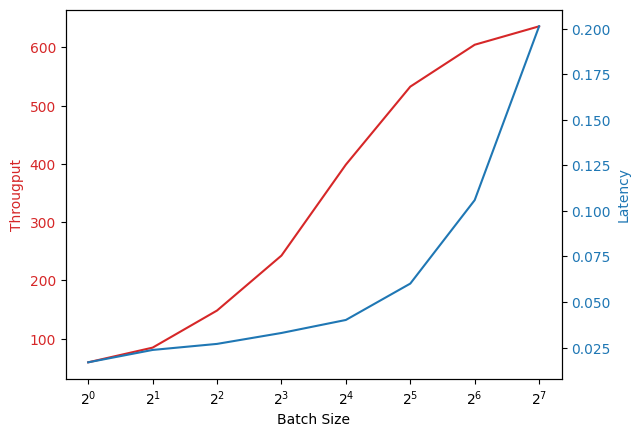

In [29]:
render_plot(x=batch_sizes, y1=throughputs, y2=latencies, x_label="Batch Size", y1_label="Througput", y2_label="Latency")